# Test log-ratios derived from differential abundance metrics on the test dataset

In [290]:
import math
import random
import sklearn
import pandas as pd
import numpy as np
import biom
import matplotlib
from matplotlib import pyplot
from sklearn.linear_model import LogisticRegression

In [267]:
# Get the LaTeX math mode stuff working as expected: https://stackoverflow.com/a/23856968
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']

In [268]:
# Set a random seed for NumPy for the jitterplots used below; from
# https://numpy.org/doc/stable/reference/random/generated/numpy.random.seed.html
#from numpy.random import MT19937, RandomState, SeedSequence
#RandomState(MT19937(SeedSequence(333)))

In [269]:
metadata = pd.read_csv("../data/final_metadata.tsv", sep="\t", index_col=0)

In [270]:
cancer_metadata = metadata.loc[metadata["Status"] != "N"]

In [271]:
testcm = cancer_metadata.loc[cancer_metadata["TrainTest"] == "Test"]
traincm = cancer_metadata.loc[cancer_metadata["TrainTest"] == "Train"]
print(f"{testcm.shape[0]} test cancer samples.")
print(f"{traincm.shape[0]} train cancer samples.")
testcm

29 test cancer samples.
67 train cancer samples.


,Age,Gender,Status,TotalNumReads,NumUniquelyMappedReads,UniquelyMappedReadsPercentage,CancerSubtype,ChemotherapyStatus,GnRHTherapyStatus,TAMTherapyStatus,AITherapyStatus,BSOTherapyStatus,TrainTest
SampleID,,,,,,,,,,,,,
C2,43.35,Female,C-R,"7,870,895","6,526,361",82.92%,TripleNegative,A,NaN,NaN,NaN,NaN,Test
C4,41.42,Female,C-R,"8,248,171","7,041,599",85.37%,TripleNegative,A,NaN,NaN,NaN,NaN,Test
C5,42.12,Female,C-R,"9,233,397","7,922,603",85.80%,LuminalA/Normal-like,D,B,B,NaN,NaN,Test
C6,36.52,Female,C-R,"7,156,841","6,140,656",85.80%,LuminalA/Normal-like,A,B,NaN,NaN,NaN,Test
C8,37.35,Female,C-R,"8,374,268","7,298,256",87.15%,LuminalA/Normal-like,A,NaN,B,NaN,NaN,Test
C11,44.98,Female,C-R,"6,848,186","5,824,106",85.05%,LuminalA/Normal-like,A,NaN,NaN,NaN,NaN,Test
C12,34.71,Female,C-R,"7,093,422","5,976,848",84.26%,TripleNegative,D,NaN,NaN,NaN,NaN,Test
C15,36.61,Female,C-R,"7,620,354","6,510,882",85.44%,TripleNegative,A,NaN,NaN,NaN,NaN,Test
C26,38.41,Female,C-R,"7,799,765","6,661,309",85.40%,HER2Enriched,A,A,NaN,NaN,NaN,Test


In [272]:
with open("output/cancer_table_with_header.tsv", "r") as cancer_tsv_file:
    tbl = biom.Table.from_tsv(cancer_tsv_file, None, None, lambda x: x)
tbl

60675 x 96 <class 'biom.table.Table'> with 2631345 nonzero entries (45% dense)

## Evaluate Songbird results

In [273]:
lr_features = pd.read_csv("output/songbird-results/selected_features_topbottom5pct.tsv", sep="\t", index_col=0)
lr_features

,Log_Ratio_Classification
Feature ID,
ENSG00000261857,Denominator
ENSG00000280236,Denominator
ENSG00000156076,Denominator
ENSG00000248822,Denominator
ENSG00000173486,Denominator
...,...
ENSG00000173267,Numerator
ENSG00000185338,Numerator
ENSG00000175063,Numerator


In [274]:
# 1. Compute log-ratio for all training samples in the table. Show jitterplot. Should match Qurro plot.
# 2. Compute log-ratio for all test samples in the table. Show jitterplot.
# 3. Perform k-means clustering with k=2 on the test sample log-ratios.
# 4. Find cluster centers. Set samples in the cluster with lower center to nonrecurrent, and samples in the
#    cluster with higher center to recurrent.
# 5. Show jitterplot of test sample log-ratios, again split up into (true) recurrence vs. nonrecurrence.
#    This time color samples by ASSIGNED recurrence vs. nonrecurrence (or just Green for good and Purple for bad
#    idk).

In [323]:
def lr_boxjitterplot(sampledf, lr_features_df, title, ax, sampleid2color=None):
    """The returned log-ratios will match the order of train and test samples, respectively,
       in sampledf.index.
    """

    num_features = lr_features_df.loc[lr_features_df["Log_Ratio_Classification"] == "Numerator"].index
    den_features = lr_features_df.loc[lr_features_df["Log_Ratio_Classification"] == "Denominator"].index

    # These are now "vectors" of sample IDs by sums
    def filter_and_sum_tbl(t, features, samples):
        featurefiltered_tbl = t.filter(features, axis="observation", inplace=False)
        samplefiltered_tbl = featurefiltered_tbl.filter(samples, axis="sample", inplace=False)
        return samplefiltered_tbl.sum(axis="sample")

    num_sum = filter_and_sum_tbl(tbl, num_features, sampledf.index)
    den_sum = filter_and_sum_tbl(tbl, den_features, sampledf.index)

    sampleid2logratio = {}
    cr_logratios = []
    cn_logratios = []
    # The numpy arrays representing the summed tables above don't really have sample labels any more,
    # but the samples seem to be in the same order as in sampledf.index.
    # Ideally we would do this more safely, since I am not 100% sure this order staying constant is guaranteed.
    for si, samp in enumerate(sampledf.index):
        logratio = math.log(num_sum[si] / den_sum[si], math.e)
        samp_status = sampledf["Status"][samp]
        if samp_status == "C-R":
            cr_logratios.append(logratio)
        elif samp_status == "C-N":
            cn_logratios.append(logratio)
        else:
            raise ValueError("excuse me")
            
        sampleid2logratio[samp] = logratio

    # Draw a horizontal grid, but behind the bars: to do this we use distinct zorders.
    # From https://stackoverflow.com/a/23358722.
    ax.grid(axis="y", zorder=0)

    # Draw a nice boxplot...
    ax.boxplot([cn_logratios, cr_logratios], labels=["C-N", "C-R"], zorder=100, sym="",
               medianprops={"color": "#000000", "linewidth": 3}, boxprops={"linewidth": 3},
               whiskerprops={"linewidth": 2}, capprops={"linewidth": 2})

    # ... and also draw the actual points behind the scatterplot at low transparency.
    # This approach is based on https://stackoverflow.com/a/29780292, which was in turn based on
    # https://nbviewer.jupyter.org/gist/fonnesbeck/5850463.
    jitter = 0.12
    get_jitter = lambda x: ((random.random() * jitter * random.choice([1, -1]))) + x
    for si, samp in enumerate(sampledf.index):
        samp_status = sampledf["Status"][samp]
        
        # matplotlib uses x values of 1 for C-N (the first boxplot category)
        # and 2 for C-R. No idea why these are 1-indexed instead of 0-indexed (using x=0 didn't
        # seem to show any points...?), but I'm not gonna question it.
        if samp_status == "C-N":
            x = get_jitter(1)
        else:
            x = get_jitter(2)
        
        if sampleid2color is None:
            sc = "#007799" if samp_status == "C-N" else "#cc3300"
        else:
            sc = sampleid2color[samp]
            
        ax.scatter(x, sampleid2logratio[samp], alpha=0.5, color=sc, zorder=5)

    # To make the plot look prettier (?) hide the top and right lines. From https://stackoverflow.com/a/28720127.
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.set_title(title, fontsize=16)
    ax.set_ylabel("Log-Ratio", fontsize=15)
    ax.set_xlabel("Recurrence Status", fontsize=15)

    ax.tick_params(labelsize=16)
    
    return sampleid2logratio

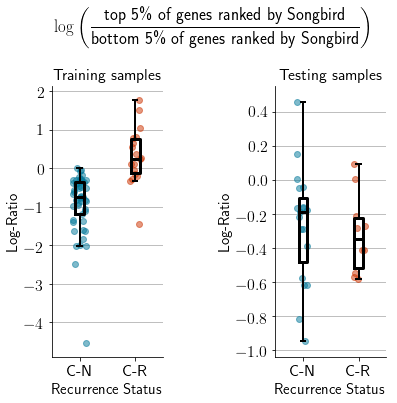

In [324]:
fig, (ax1, ax2) = pyplot.subplots(1, 2, gridspec_kw={"wspace": 1})

trsamp2lr = lr_boxjitterplot(traincm, lr_features, "Training samples", ax1)
tesamp2lr = lr_boxjitterplot(testcm, lr_features, "Testing samples", ax2)

fig.suptitle("$\log \\bigg(\\dfrac{\\text{top 5\% of genes ranked by Songbird}}{\\text{bottom 5\% of genes ranked by Songbird}}$\\bigg)", fontsize=17, y=1.1, fontweight="bold")
fig.set_size_inches(6, 5)
fig.savefig("../figs/results/songbird-5pct-logratios.png", bbox_inches="tight")

## Apply logistic regression to the data: see how well the log-ratio generalizes to the test data

In [281]:
def logistic_regression_on_logratios(trsamp2lr, tesamp2lr):
    
    # 0 for C-N (nonrecurrent), 1 for C-R (recurrent)
    training_truth_classes = []
    input_training_data = []
    training_sample_order = list(trsamp2lr.keys())
    for samp in training_sample_order:
        if traincm["Status"][samp] == "C-N":
            training_truth_classes.append(0)
        else:
            training_truth_classes.append(1)
        # Needs to be a 2-D array
        input_training_data.append([trsamp2lr[samp]])
            
    lrm = LogisticRegression(random_state=333).fit(input_training_data, training_truth_classes)
        
    test_truth_classes = []
    input_test_data = []
    test_sample_order = list(tesamp2lr.keys())
    for samp in test_sample_order:
        if testcm["Status"][samp] == "C-N":
            test_truth_classes.append(0)
        else:
            test_truth_classes.append(1)
        input_test_data.append([tesamp2lr[samp]])
    
    predictions = lrm.predict(input_test_data)
    
    print("Test ground truths:", test_truth_classes)
    print("Test predictions:  ", list(predictions))
    
    # We are a bit lazy here, and rather than directly mapping samples to false positive, false negative,
    # true positive, true negative we just map them to the color of their classification. this should make
    # visually highlighting misclassifications obvious on a plot.
    testsamp2color = {}
    
    tp = fp = tn = fn = 0
    for si, samp in enumerate(test_sample_order):
        real_val = test_truth_classes[si]
        pred_val = predictions[si]
        if real_val == 0:
            if pred_val == 0:
                tn += 1
                testsamp2color[samp] = "#007799"
            else:
                fp += 1
                testsamp2color[samp] = "#cc3300"
        else:
            if pred_val == 0:
                fn += 1
                testsamp2color[samp] = "#007799"
            else:
                tp += 1
                testsamp2color[samp] = "#cc3300"
                
    print(f"True positives: {tp}")
    print(f"False positives: {fp}")
    print(f"True negatives: {tn}")
    print(f"False negatives: {fn}")
    
    acc = (tp + tn) / (tp + tn + fp + fn)
    
    print(f"Accuracy: {100*acc:.2f}%")
    
    return (tp, fp, tn, fn, testsamp2color)

In [282]:
tp, fp, tn, fn, sid2color = logistic_regression_on_logratios(trsamp2lr, tesamp2lr)

Test ground truths: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Test predictions:   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True positives: 0
False positives: 2
True negatives: 17
False negatives: 10
Accuracy: 58.62%


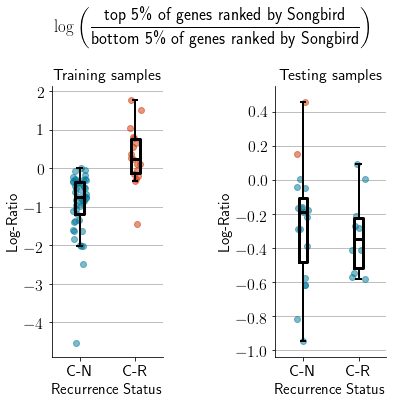

In [326]:
fig, (ax1, ax2) = pyplot.subplots(1, 2, gridspec_kw={"wspace": 1})

lr_boxjitterplot(traincm, lr_features, "Training samples", ax1)
lr_boxjitterplot(testcm, lr_features, "Testing samples", ax2, sid2color)

fig.suptitle("$\log \\bigg(\\dfrac{\\text{top 5\% of genes ranked by Songbird}}{\\text{bottom 5\% of genes ranked by Songbird}}$\\bigg)", fontsize=17, y=1.1, fontweight="bold")
fig.set_size_inches(6, 5)
fig.savefig("../figs/results/songbird-5pct-logratios-with-test-classifications.png", bbox_inches="tight")